# 10장 시계열 데이터와 순환 신경망

**감사말**: 프랑소와 숄레의 [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff) 10장에 사용된 코드에 대한 설명을 담고 있으며 텐서플로우 2.6 버전에서 작성되었습니다. 소스코드를 공개한 저자에게 감사드립니다.

**tensorflow 버전과 GPU 확인**
- 구글 코랩 설정: '런타임 -> 런타임 유형 변경' 메뉴에서 GPU 지정 후 아래 명령어 실행 결과 확인

    ```
    !nvidia-smi
    ```

- 사용되는 tensorflow 버전 확인

    ```python
    import tensorflow as tf
    tf.__version__
    ```
- tensorflow가 GPU를 사용하는지 여부 확인

    ```python
    tf.config.list_physical_devices('GPU')
    ```

## 주요내용

- 시계열 데이터 머신러닝 과제 예제
- 순환신경망(RNN, recurrent neural network) 이해
- 온도 예측 RNN 모델 구현
- 고급 RNN 활용 패턴

## 10.1 시계열 데이터 예제

**시계열**(timeseries)은 일정 간격으로 측정된 값들로 이루어진 데이터이다. 

- 일일 단위 증시 가격
- 도시의 시간당 소비 전력
- 매장의 주별 판매량

시계열은 자연현상 및 사람들의 일상에서 쉽게 구할 수 있다.

- 지진 활동
- 물고기 개체수
- 지역 날씨
- 웹사이트 방문자수
- 국내총생산(GDP)

시계열과 관련된 대표적인 과제는 **예측**(forcasting)이다. 
예를 들어, 몇 시간 후의 소비 전력, 몇 달 후의 영업 이익, 며칠 뒤의 날씨 등을 예측하는 일이다. 
이외에 시계열과 관련된 과제는 다음과 같다.

- 분류(classification): 웹사이트 방문자의 활동 이력을 보고 사람인지 여부 판단
- 이벤트 탐지(event detection): 오디오 스트림 감시 도중 "Ok Google", "Hey Alexa", "시리야" 등 핫워드(hotword) 탐지
- 이상치 탐지(anomaly detection): 생산라인 중에 발생하는 특이현상, 회사 네트워크 상에 발생하는 특이 활동 등 탐지.
    비지도 학습 활용.

## 10.2 예제: 온도 예측

나머지 이야기는 24시간 이후의 온도를 예측하는 모델을 구현하는 것이다. 
적절한 모델 구현과정을 통해 기존에 사용했던 밀집 연결 모델, 합성곱 모델 등은 적절하지 않고 
시계열 데이터에 대한 새로운 접근방식을 사용하는 **순환 신경망**(recurrent neural network, RNN)이
훨씬 잘 작동함을 보게 될 것이다. 

### 데이터셋 준비

독일 예나(Jena)시에 위치한 막스-플랑크(Max-Planck) 생지화확(Biogeochemistry) 연구소가
수 년동안 온도, 기압, 풍향 등 14 종류의 기상 데이터를 10분 단위로 측정해서 수집한 데이터셋이다. 
원래 2003년부터 측정하였지만 여기서는 2009-2016년 데이터만 이용한다. 

**zip 파일 다운로드 및 압축풀기**

"jena_climate_2009_2016.csv" 파일이 생성된다.

In [3]:
import wget, zipfile

wget.download('https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip')

with zipfile.ZipFile('jena_climate_2009_2016.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

100% [........................................................................] 13565642 / 13565642

**예나(Jena) 날씨 데이터셋 살펴보기**

파일을 열어 줄(line) 단위로 쪼갠다.

In [10]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")

첫째 줄은 날짜와 시간 이외에 14개의 특성명이 쉼표(콤마)로 구분되어 있으며,
총 420,451개의 데이터를 포함한다.

In [11]:
header = lines[0].split(",")
lines = lines[1:]

In [12]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [13]:
print(len(lines))

420451


첫째 데이터는 2009년 1월 1일 0시 10분에 측정되었다.

In [14]:
lines[0]

'01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30'

In [21]:
lines[0].split(',')

['01.01.2009 00:20:00',
 '996.57',
 '-8.41',
 '265.01',
 '-9.28',
 '93.40',
 '3.23',
 '3.02',
 '0.21',
 '1.89',
 '3.03',
 '1309.80',
 '0.72',
 '1.50',
 '136.10']

2번 인덱스 항목이 섭씨 온도이다. 

In [21]:
lines[0].split(',')[2]

['01.01.2009 00:20:00',
 '996.57',
 '-8.41',
 '265.01',
 '-9.28',
 '93.40',
 '3.23',
 '3.02',
 '0.21',
 '1.89',
 '3.03',
 '1309.80',
 '0.72',
 '1.50',
 '136.10']

**넘파이 어레이로 변환**

In [29]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]

    temperature[i] = values[1]    # i 번째 온도
    raw_data[i, :] = values[:]    # i 번째 데이터

**온도 변화 그래프**

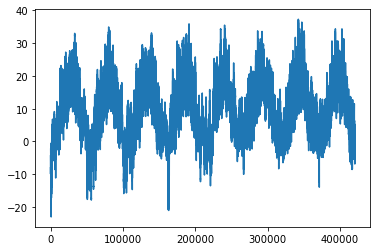

In [30]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

**처음 10일동안의 온도 변화**

한 시간에 6번, 하루 24시간, 10일동안 측정 횟수는 `6 * 24 * 10 = 1,440`이다.

- 1월 1일 - 1월 10일 기간동안 측정된 온도라 상당히 낮다.
- 마지막 4일 동안은 일 단위 온도 변화가 주기성을 띈다. 

**주기성**(periodicity)은 시계열 데이터의 기본 특성 중 하나이다.
월별 주기성은 매우 일관성을 갖는다. 
지난 몇 달동안의 데이터를 이용하여 다음 달의 평균 온도를 예측하는 일은 상대적으로 쉽다.
반면에 일 단위의 예측은 아래 그래프에서 보듯이 훨씬 혼잡하다. 

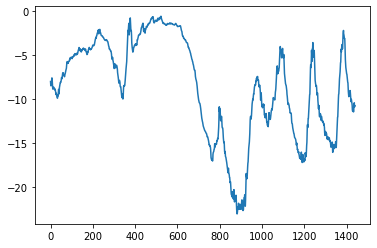

In [31]:
plt.plot(range(1440), temperature[:1440])

**훈련셋, 검증셋, 테스트셋 크기**

- 훈련셋: 전체의 50%
- 검증셋: 전체의 25%
- 테스트셋: 전체의 25%

미래에 대한 예측을 실행하므로 훈련셋, 검증셋, 테스트셋 순으로 
보다 오래된 데이터를 사용한다. 

In [32]:
num_train_samples = int(0.5 * len(raw_data))     # 전체의 50%
num_val_samples   = int(0.25 * len(raw_data))    # 전체의 25%
num_test_samples  = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### 데이터 전처리

**데이터 정규화**

In [33]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

**참고**: `timeseries_dataset_from_array()` 활용법

In [37]:
from tensorflow import keras

int_sequence = np.arange(10)

dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

In [45]:
i = 0
for inputs, targets in dummy_dataset:
    print(f"배치 {i}: ", end="")
    print("\t samples shape:", inputs.shape)
    print("\t targets shape:", targets.shape)
    i += 1

배치 0: 	 samples shape: (2, 3)
	 targets shape: (2,)
배치 1: 	 samples shape: (2, 3)
	 targets shape: (2,)
배치 2: 	 samples shape: (1, 3)
	 targets shape: (1,)


In [46]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating Datasets for training, validation, and testing.**

- `shuffle=True`: 생성된 시퀀스들의 순서 무작위화
- `start_index`: 대상 데이터셋 시작 구간
- `end_index`: 대상 데이터셋 끝 구간

In [35]:
# 1시간에 하나의 데이터 선택
sampling_rate = 6

# 입력 데이터 시퀀스: 지난 5일치(120시간) 온도 데이터
sequence_length = 120

# 타깃 설정:24시간 이후의 온도. 지연(delay)을 6일치로 지정
delay = sampling_rate * (sequence_length + 24 - 1)

# 배치 크기
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True, # 생성된 시퀀스들의 순서 무작위화
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our Datasets.**

In [36]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [47]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]  # 원 데이터로 되돌리기
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine learning model

**Training and evaluating a densely connected model**

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 8s 7ms/step - loss: 17.7411 - mae: 3.2404 - val_loss: 11.6390 - val_mae: 2.6975
Epoch 2/10
819/819 [==============================] - 6s 7ms/step - loss: 9.7537 - mae: 2.4601 - val_loss: 10.9157 - val_mae: 2.6036
Epoch 3/10
819/819 [==============================] - 6s 7ms/step - loss: 8.5777 - mae: 2.3106 - val_loss: 10.9692 - val_mae: 2.6036
Epoch 4/10
819/819 [==============================] - 5s 7ms/step - loss: 7.9155 - mae: 2.2180 - val_loss: 11.8010 - val_mae: 2.6920
Epoch 5/10
819/819 [==============================] - 5s 7ms/step - loss: 7.5347 - mae: 2.1667 - val_loss: 11.1201 - val_mae: 2.6140
Epoch 6/10
819/819 [==============================] - 6s 7ms/step - loss: 7.2795 - mae: 2.1293 - val_loss: 11.8688 - val_mae: 2.7086
Epoch 7/10
819/819 [==============================] - 5s 7ms/step - loss: 7.0453 - mae: 2.0957 - val_loss: 11.5212 - val_mae: 2.6549
Epoch 8/10
819/819 [==============================] - 5s 7ms/step - 

**Plotting results**

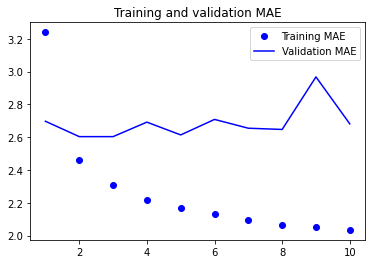

In [50]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [51]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 21s 11ms/step - loss: 21.8452 - mae: 3.6470 - val_loss: 14.7968 - val_mae: 3.0281
Epoch 2/10
819/819 [==============================] - 8s 10ms/step - loss: 15.4383 - mae: 3.1202 - val_loss: 16.2417 - val_mae: 3.1931
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 14.2513 - mae: 2.9955 - val_loss: 14.2133 - val_mae: 2.9704
Epoch 4/10
819/819 [==============================] - 8s 10ms/step - loss: 13.4321 - mae: 2.9021 - val_loss: 14.1744 - val_mae: 2.9601
Epoch 5/10
819/819 [==============================] - 8s 10ms/step - loss: 12.7650 - mae: 2.8243 - val_loss: 16.7548 - val_mae: 3.2521
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 12.2057 - mae: 2.7555 - val_loss: 13.4107 - val_mae: 2.8708
Epoch 7/10
819/819 [==============================] - 8s 10ms/step - loss: 11.7257 - mae: 2.6982 - val_loss: 18.8073 - val_mae: 3.4561
Epoch 8/10
819/819 [==============================] - 

### A first recurrent baseline

**A simple LSTM-based model**

In [52]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print("Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 12ms/step - loss: 40.9480 - mae: 4.6539 - val_loss: 12.3689 - val_mae: 2.6786
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 10.9888 - mae: 2.5722 - val_loss: 9.6240 - val_mae: 2.4246
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 9.7614 - mae: 2.4405 - val_loss: 10.0359 - val_mae: 2.4824
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 9.3485 - mae: 2.3877 - val_loss: 9.8008 - val_mae: 2.4443
Epoch 5/10
819/819 [==============================] - 9s 12ms/step - loss: 8.9973 - mae: 2.3416 - val_loss: 9.9759 - val_mae: 2.4650
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 8.7272 - mae: 2.3096 - val_loss: 10.1388 - val_mae: 2.4820
Epoch 7/10
819/819 [==============================] - 9s 12ms/step - loss: 8.4632 - mae: 2.2737 - val_loss: 10.0683 - val_mae: 2.4803
Epoch 8/10
819/819 [==============================] - 10s 12ms

## 10.3 Understanding recurrent neural networks

- 순방향 신경망(feedforward network)
- 순환 신경망(recurrent neural network)

**NumPy implementation of a simple RNN**

In [76]:
timesteps = 100

input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []

for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

In [77]:
final_output_sequence.shape

(100, 64)

### A recurrent layer in Keras

**A RNN layer that can process sequences of any length**

In [ ]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**A RNN layer that returns only its last output step**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

**A RNN layer that returns its full output sequence**

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

**Stacking RNN layers**

In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

### *_Going even further_*

## Chapter summary